In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

from PIL import Image
from sklearn.model_selection import train_test_split
import time
import random
from datetime import datetime
import cv2

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {"rbg": {"mean": mean[:3],
                                "std": std[:3]},
                        "depth": {"mean": mean[3],
                                  "std": std[3]},
                        "normal": {"mean": mean[4:],
                                   "std": std[4:]}}

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    
    # Perform horizontal flip of the image with a probability of 0.5
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(**params.learning.JITTER_PARAMS),

    # Randomly adds a black patch to the image
    Cutout(0.5),
    
    # Randomly cast a shadow on the image
    Shadowcasting(0.5),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=NORMALIZE_PARAMS["rbg"]["mean"],
        std=NORMALIZE_PARAMS["rbg"]["std"]
    ),
])

transform_depth = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"]
        ),
])

transform_normal = transforms.Compose([
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"]
        ),
])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_train.csv",
    images_directory=params.learning.DATASET+"images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET+"traversal_costs_test.csv",
    images_directory=params.learning.DATASET+"images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE/(1-params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (408 samples)
15.0 % of the data for validation (88 samples)
15.0 % of the data for testing (88 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model
model = ResNet18Velocity(**params.learning.NET_PARAMS).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(32,
                     params.learning.NET_PARAMS["nb_input_channels"],
                     params.learning.IMAGE_SHAPE[0],
                     params.learning.IMAGE_SHAPE[1]).to(device=device)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32, 10])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [11]:
# Define the loss function (combines nn.LogSoftmax() and nn.NLLLoss())
criterion_classification = nn.CrossEntropyLoss()

# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Load the bins midpoints
bins_midpoints = np.load(params.learning.DATASET+"bins_midpoints.npy")
bins_midpoints = torch.tensor(bins_midpoints[:, None],
                              dtype=torch.float32,
                              device=device)

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss and accuracy values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy, train_regression_loss = train(model,
                                                              device,
                                                              train_loader,
                                                              optimizer,
                                                              criterion_classification,
                                                              criterion_regression,
                                                              bins_midpoints,
                                                              epoch)
    
    # Validation
    val_loss, val_accuracy, val_regression_loss = validate(model,
                                                           device,
                                                           val_loader,
                                                           criterion_classification,
                                                           criterion_regression,
                                                           bins_midpoints,
                                                           epoch) 
    
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy
    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss
    
#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  18.627450980392158
Validation accuracy:  25.0
Train regression loss:  14.493967569791353
Validation regression loss:  14.62710158030192


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  17.892156862745097
Validation accuracy:  26.136363636363637
Train regression loss:  12.956051679757925
Validation regression loss:  12.945786476135254


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  21.568627450980394
Validation accuracy:  27.272727272727273
Train regression loss:  11.222253285921537
Validation regression loss:  11.329036712646484


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  27.45098039215686
Validation accuracy:  38.63636363636363
Train regression loss:  9.793703996218168
Validation regression loss:  9.592812379201254


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  30.637254901960784
Validation accuracy:  31.818181818181817
Train regression loss:  8.519595769735483
Validation regression loss:  8.587265173594156


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  29.41176470588235
Validation accuracy:  34.09090909090909
Train regression loss:  7.593283066382775
Validation regression loss:  7.931981881459554


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  28.676470588235293
Validation accuracy:  35.22727272727273
Train regression loss:  6.815876337198111
Validation regression loss:  7.057062149047852


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  29.41176470588235
Validation accuracy:  35.22727272727273
Train regression loss:  6.181791085463304
Validation regression loss:  6.459121863047282


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  28.186274509803923
Validation accuracy:  37.5
Train regression loss:  5.693213426149809
Validation regression loss:  6.096697171529134


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  29.166666666666668
Validation accuracy:  37.5
Train regression loss:  5.281333886660063
Validation regression loss:  5.6765163739522295


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  30.392156862745097
Validation accuracy:  38.63636363636363
Train regression loss:  4.993159147409292
Validation regression loss:  5.191386858622233


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  27.45098039215686
Validation accuracy:  39.77272727272727
Train regression loss:  4.706979256409865
Validation regression loss:  5.041114489237468


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  29.901960784313726
Validation accuracy:  39.77272727272727
Train regression loss:  4.51611142892104
Validation regression loss:  4.847582181294759


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  30.637254901960784
Validation accuracy:  36.36363636363637
Train regression loss:  4.3696121619297905
Validation regression loss:  4.661684513092041


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.61764705882353
Validation accuracy:  36.36363636363637
Train regression loss:  4.217734997089092
Validation regression loss:  4.415100018183391


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.127450980392158
Validation accuracy:  37.5
Train regression loss:  4.123802588536189
Validation regression loss:  4.473695278167725


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  33.8235294117647
Validation accuracy:  35.22727272727273
Train regression loss:  4.0286790774418755
Validation regression loss:  4.306797027587891


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  32.59803921568628
Validation accuracy:  35.22727272727273
Train regression loss:  3.9055105356069713
Validation regression loss:  4.387236913045247


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  32.35294117647059
Validation accuracy:  35.22727272727273
Train regression loss:  3.89318794470567
Validation regression loss:  3.97796368598938


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.127450980392158
Validation accuracy:  35.22727272727273
Train regression loss:  3.835532316794762
Validation regression loss:  4.103269735972087


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  30.637254901960784
Validation accuracy:  34.09090909090909
Train regression loss:  3.8187559934762807
Validation regression loss:  3.9549560546875


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  30.392156862745097
Validation accuracy:  35.22727272727273
Train regression loss:  3.752156220949613
Validation regression loss:  4.058221022288005


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.127450980392158
Validation accuracy:  32.95454545454545
Train regression loss:  3.700453703220074
Validation regression loss:  3.9511496225992837


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.862745098039216
Validation accuracy:  31.818181818181817
Train regression loss:  3.737698848430927
Validation regression loss:  3.9727749824523926


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.862745098039216
Validation accuracy:  30.681818181818183
Train regression loss:  3.705001170818622
Validation regression loss:  3.8252787590026855


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  32.84313725490196
Validation accuracy:  31.818181818181817
Train regression loss:  3.668586254119873
Validation regression loss:  3.810567855834961


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  33.57843137254902
Validation accuracy:  30.681818181818183
Train regression loss:  3.6136782352740946
Validation regression loss:  3.592952330907186


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.372549019607842
Validation accuracy:  31.818181818181817
Train regression loss:  3.6350255012512207
Validation regression loss:  3.6930387020111084


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  33.8235294117647
Validation accuracy:  31.818181818181817
Train regression loss:  3.62766249363239
Validation regression loss:  3.6565916538238525


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  34.068627450980394
Validation accuracy:  31.818181818181817
Train regression loss:  3.58810437642611
Validation regression loss:  3.6729981899261475


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  32.59803921568628
Validation accuracy:  30.681818181818183
Train regression loss:  3.5571026618664083
Validation regression loss:  3.818425258000692


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  33.088235294117645
Validation accuracy:  30.681818181818183
Train regression loss:  3.5800294876098633
Validation regression loss:  3.7258527278900146


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  33.8235294117647
Validation accuracy:  30.681818181818183
Train regression loss:  3.5653948600475607
Validation regression loss:  3.7270216941833496


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  32.35294117647059
Validation accuracy:  29.545454545454547
Train regression loss:  3.5504356714395375
Validation regression loss:  3.6854260762532554


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  33.8235294117647
Validation accuracy:  28.40909090909091
Train regression loss:  3.5127859665797305
Validation regression loss:  3.7442057132720947


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  34.31372549019608
Validation accuracy:  28.40909090909091
Train regression loss:  3.5248388143686147
Validation regression loss:  3.5443905194600425


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  31.127450980392158
Validation accuracy:  26.136363636363637
Train regression loss:  3.510147608243502
Validation regression loss:  3.7813464800516763


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  34.55882352941177
Validation accuracy:  30.681818181818183
Train regression loss:  3.509770384201637
Validation regression loss:  3.598188559214274


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  34.55882352941177
Validation accuracy:  29.545454545454547
Train regression loss:  3.502704216883733
Validation regression loss:  3.637875239054362


  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/3 [00:00<?, ?batch/s]

Train accuracy:  35.049019607843135
Validation accuracy:  32.95454545454545
Train regression loss:  3.4479197538816013
Validation regression loss:  3.5316895643870034


### Visualization

Text(0.5, 0, 'Epoch')

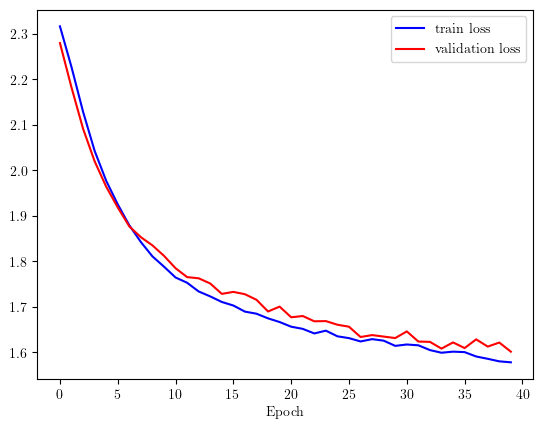

In [12]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

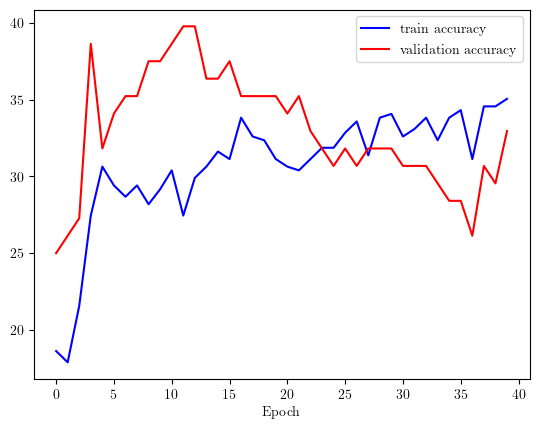

In [13]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

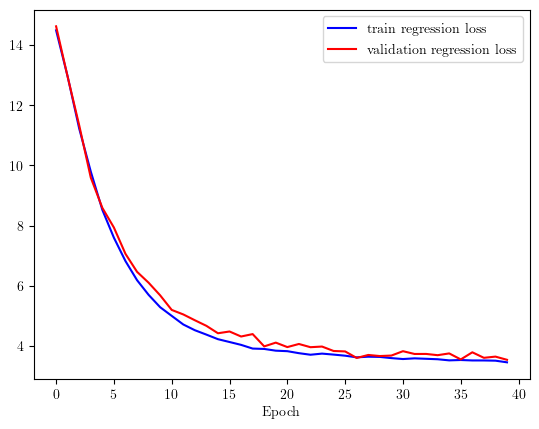

In [14]:
# Regression loss
train_regression_losses = regression_loss_values[0]
val_regression_losses = regression_loss_values[1]

plt.plot(train_regression_losses, "b", label="train regression loss")
plt.plot(val_regression_losses, "r", label="validation regression loss")

plt.legend()
plt.xlabel("Epoch")

## Testing

#### Testing the model

In [15]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
_,\
test_accuracy,\
test_regression_loss,\
test_regression_losses,\
uncertainties = test(model,
                     device,
                     test_loader,
                     criterion_classification,
                     criterion_regression,
                     bins_midpoints,
                     uncertainty_function)

print("Test accuracy: ", test_accuracy)
print("Regression loss: ", test_regression_loss)

Test accuracy:  40.90909090909091
Regression loss:  3.627650817235311


#### Comparing to the worst possible loss

In [16]:
from sklearn.preprocessing import KBinsDiscretizer

dataset_dir = params.learning.DATASET+"traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)
costs = costs_df['traversal_cost'].to_numpy()
mean_dataset_value = costs_df['traversal_cost'].mean()

print(mean_dataset_value)


discretizer = KBinsDiscretizer(
            n_bins=10,
            encode="ordinal",
            strategy="quantile")
discretizer.fit(costs.reshape(-1, 1))
edges = discretizer.bin_edges_[0]
midpoints = (edges[:-1] + edges[1:])/2
print(midpoints)

mean_dataset_label = np.int32(discretizer.transform(mean_dataset_value.reshape(1, -1)))

mean_loss = 0.

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images,\
    traversal_costs,\
    traversability_labels,\
    linear_velocities in train_loader_pbar:
    mean_tensor_label = torch.tensor(np.full(list(traversability_labels.shape), mean_dataset_label), dtype=torch.int64)
    mean_tensor_value = torch.tensor(np.full(list(traversal_costs.shape), mean_dataset_value), dtype=torch.float32)

    #loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    #train_loss += loss.item()
    #
    ## Get the number of correct predictions
    #train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()
    
    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value,
        traversal_costs).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)
    
print(mean_loss)



2.951423715066781
[0.37651514 1.04366292 1.60653171 2.09063548 2.53667356 2.97943666
 3.39412605 3.94569341 4.92779983 9.36994781]


100%|██████████| 13/13 [00:01<00:00,  7.38batch/s]

3.4839848555051365


#### Getting some stats about the dataset

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

dataset_dir = params.learning.DATASET+"traversal_costs.csv"
costs_df = pd.read_csv(dataset_dir)

display(costs_df.groupby(['traversability_label']).count())

,image_id,traversal_cost,linear_velocity
traversability_label,,,
0,120,120,120
1,156,156,156
2,168,168,168
3,72,72,72
4,46,46,46
5,15,15,15
6,3,3,3
7,2,2,2
8,1,1,1


## Save model parameters

In [18]:
# Save the model parameters
# torch.save(model.state_dict(), "multimodal_velocity.params")

## Assessing the relevance of the uncertainty

In [19]:
import uncertainty.functions
import uncertainty.evaluation

# Compute the test losses after successive removal of the samples
# with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty =\
    uncertainty.evaluation.uncertainty_relevance(
        model,
        device,
        criterion_classification,
        criterion_regression,
        bins_midpoints,
        uncertainty_function,
        test,
        test_set,
        test_regression_loss,
        test_regression_losses,
        uncertainties)

#### Plotting the results

Text(0, 0.5, 'Regression error (MSE)')

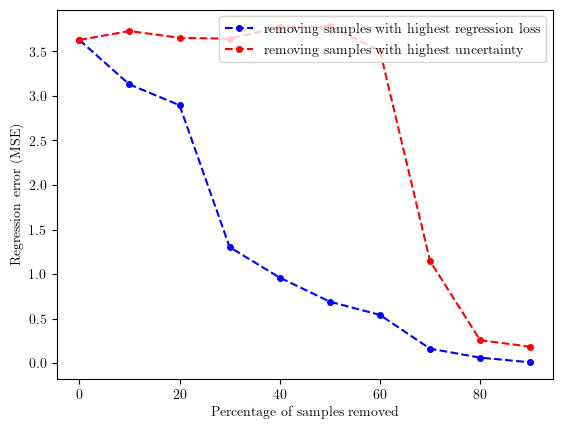

In [20]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")

## Generate a log directory

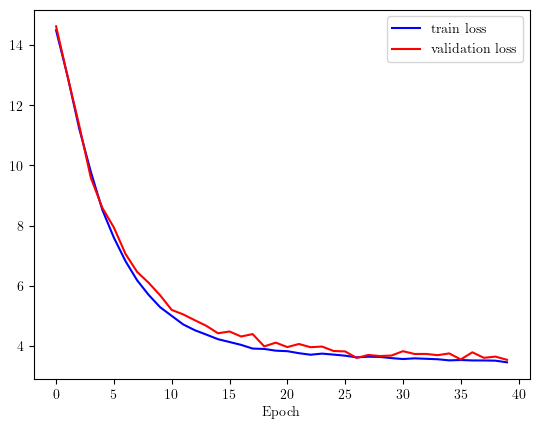

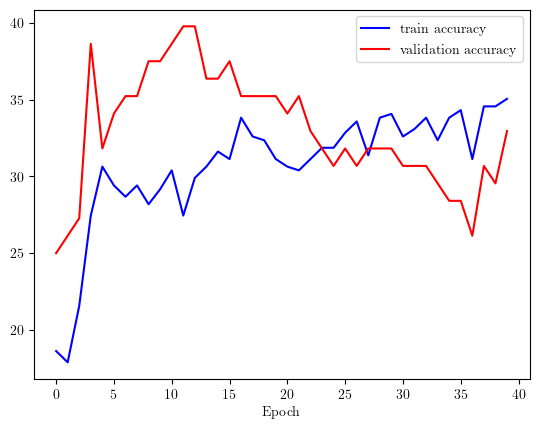

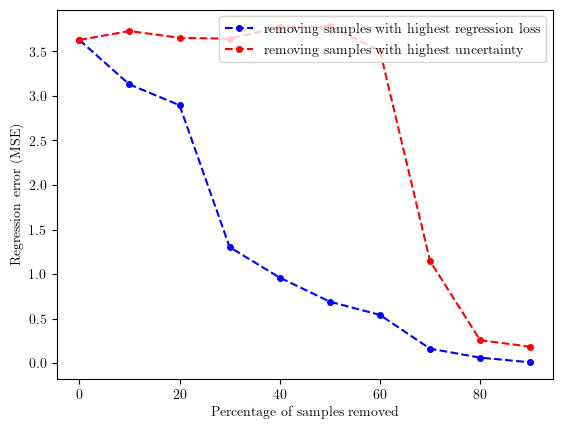

In [21]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.learning.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = "logs/_" +\
                        params.learning.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(results_directory=results_directory,
             test_regression_loss=test_regression_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             regression_loss_values=regression_loss_values,
             accuracy_values=accuracy_values,
             test_losses_loss=test_losses_loss,
             test_losses_uncertainty=test_losses_uncertainty)

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    
    print(f"Training model {i+1}/{nb_models}")
    
    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [param for name, param in some_models[i].named_parameters()
                   if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD([
        {"params": base_params},
        {"params": some_models[i].resnet18.fc.parameters(),
         "lr": LEARNING_PARAMS["learning_rate"] * 10},
    ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"])
    
    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):

        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(some_models[i],
                                                                  device,
                                                                  train_loader,
                                                                  optimizer,
                                                                  criterion_classification,
                                                                  criterion_regression,
                                                                  bins_midpoints,
                                                                  epoch)

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(some_models,
                                                                          device,
                                                                          test_loader,
                                                                          criterion_classification,
                                                                          criterion_regression,
                                                                          bins_midpoints,
                                                                          uncertainty_function)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
test_losses_loss, test_losses_uncertainty = \
    uncertainty.evaluation.uncertainty_relevance_models(some_models,
                                                        device,
                                                        criterion_classification,
                                                        criterion_regression,
                                                        bins_midpoints,
                                                        uncertainty_function,
                                                        test_models,
                                                        test_set,
                                                        test_regression_loss,
                                                        test_regression_losses,
                                                        uncertainties)

#### Plotting the results

In [ ]:
plt.plot(range(0, 100, 10),
         test_losses_loss,
         "bo--",
         label="removing samples with highest regression loss",
         markersize=4)
plt.plot(range(0, 100, 10),
         test_losses_uncertainty,
         "ro--",
         label="removing samples with highest uncertainty",
         markersize=4)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")